In [1]:
from pprint import pprint
from torch_geometric.data import Data, DataListLoader, Dataset, InMemoryDataset, Batch
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.nn import *
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops, remove_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm.auto import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger

from copy import deepcopy
#from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict, Union
from torch import Tensor
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops, degree
from torch_scatter import scatter
from torch_geometric.typing import (
    Adj,
    OptTensor,
    SparseTensor,
    pyg_lib,
    torch_sparse,
)
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from rdkit import Chem
import os
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
cuda=torch.device('cuda') if torch.cuda.is_available() else 'cpu'
import sascorer
#torch.set_default_dtype(torch.float64)
from models import *
from rdkit.Chem.Crippen import MolLogP
from typing import List
from prolog import *
import torchlens as tl

In [2]:
from torch_geometric.datasets import MD17

In [3]:
def pre_transform(data):
    return Data(pos=data.pos, atom_type=data.z, energy=data.energy, force=data.force)
md17_full=MD17("datasets/md17-benzene",name='benzene',pre_transform=pre_transform)
md17=md17_full[::len(md17_full)//4096]

In [4]:
train_dataset, test_dataset = torch.utils.data.random_split(md17, [1000, len(md17)-1000])

In [5]:
class TrainingContext:
    def __init__(self, cls, *args, **kwargs):
        self.inner = cls(*args, **kwargs).to(cuda)
        self.name = cls.__name__
        self.optim = torch.optim.AdamW(self.inner.parameters())
        self.sched = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.98)
        self.num_parameters = sum(map(torch.numel,self.inner.parameters()))
        self.train_loss_record = dict()
        self.test_loss_record = dict()
        self.results = list()
        self.total_iters = 0
        self.running_loss = 0
        self.best_eval_loss = 999
        self.stopped = False
        self.batch_size=64
        self.train_loss_metric='MSE'
        self.eval_loss_metric='MAE'
        self.last_target_name='normalized energy'
        self.last_dataset_name='MD17-benzene'
        self.training=True
    def save(self, prefix='saves'):
        save_model(
            self.name,
            self.inner,
            optimizer=self.optim,
            scheduler=self.sched,
            loss_record={
                'train':self.train_loss_record,
                'test':self.test_loss_record,
            },
            total_training_iters=self.total_iters,
            last_batch_size=self.batch_size,
            loss_metric={
                'train':'MSE',
                'test':'MAE',
            },
            last_target_name=self.last_target_name,
            last_dataset_name=self.last_dataset_name
        )
    @classmethod
    def load(cls, name, class_, prefix='saves', training=False, override=None):
        if override is None:
            override=dict()
        checkpoint=torch.load(os.path.join(prefix,name,'checkpoint.pth'))
        self=cls(class_,**dict(**checkpoint['config'],**override))
        self.inner.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        self.sched.load_state_dict(checkpoint['scheduler_state_dict'])
        self.total_iters=checkpoint['total_training_iters']
        self.batch_size=checkpoint['last_batch_size']
        self.train_loss_record=checkpoint['loss_record']['train']
        self.test_loss_record=checkpoint['loss_record']['test']
        self.best_eval_loss=min(self.test_loss_record.values())
        self.training=training
        return self
    

In [6]:
import gc
models=[]
gc.collect()
torch.cuda.empty_cache()

In [7]:
from models.schnet import SchNet

models.append(TrainingContext(SchNet))
models[-1].num_parameters

455809

In [8]:
from models.m307b import M307B

models.append(TrainingContext(
    M307B,
    node_dimses=[
        [120, 150, 120],#this first element of the first nested list is arbitrary
        [120, 150, 120],
        [120, 150, 120],
        [120, 150, 120],
        [120, 150, 120],
        [120, 150, 1 ],
    ],
    edge_dimses=[
        [50, 220, 120],
        [50, 220, 120],
        [50, 220, 120],
        [50, 220, 120],
        [50, 220, 120],
        [50, 220, 120],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
))
models[-1].num_parameters

458260

(tensor(-146525.9375), tensor(9.0312), tensor(-146527.5312))

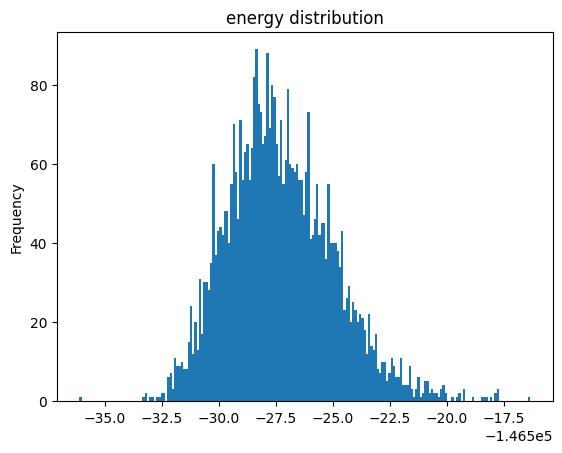

In [9]:
eng=md17.energy
__min= eng.quantile(.0001)
__max= eng.quantile(.9999)
__mid=eng.quantile(.5)
__mean=eng.mean()
__std= eng.std()
pd.Series(eng).plot.hist(bins=200)
offset=(__min+__max)/2
width=abs(__max-__min)/2
plt.title("energy distribution")
offset,width,__mid

In [10]:
import numpy as np
BATCH_SIZE=64
N_EPOCHS=100
N_mols=len(train_dataset)
long_bar=tqdm(range(N_EPOCHS*N_mols//BATCH_SIZE),smoothing=0)
e_bar=tqdm(range(N_mols//BATCH_SIZE),smoothing=0)
Q=10000
N_TRAINING_MODEL=len(models)
for model in models:
    model.inner=model.inner.train()
    model.stopped=False
    
#torch.autograd.set_detect_anomaly(True)
for epoch in range(N_EPOCHS):
    e_bar.refresh()
    e_bar.reset(N_mols//BATCH_SIZE)
    train_bl=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for i, batch in zip(range(N_mols//BATCH_SIZE), train_bl):
        long_bar.update(1)
        e_bar.update(1)
        
        try:
            batch=(batch.to(cuda))
            y=(batch.energy-__mean)/__std
            
            for model in models:
                if model.stopped or not model.training: continue
                model.inner=model.inner.train()
                out = model.inner(batch)
                extra_loss=0
                if isinstance(out, tuple):
                    out, extra_loss=out
                loss = ((out-y)**2).mean()+extra_loss
                model.inner.zero_grad(set_to_none=True)
                
                if model.total_iters<5:
                    model.running_loss = model.running_loss*.3+loss.item()*.7
                else:
                    model.running_loss = model.running_loss*(1-1/100)+loss.item()/100
                    
                if model.total_iters+.2>1.1**len(model.train_loss_record):
                    model.train_loss_record[model.total_iters]=model.running_loss
                loss.backward()
                model.optim.step()
                model.total_iters+=1

            ### evaluation
            if i%64==0:
                for model in models:
                    if model.stopped or not model.training: continue
                    model.inner=model.inner.eval()
                    L=len(test_dataset)
                    test_bl=DataLoader(test_dataset, batch_size=1024)
                    all_eval_y=list()
                    model.test_loss_record[model.total_iters]=0
                    for batch in test_bl:
                        batch=(batch.to(cuda))
                        eval_y=(batch.energy-__mean)/__std
                        all_eval_y+=eval_y.view(-1).tolist()
                        with torch.no_grad():
                            out = model.inner(batch)#X, A, E, batch=b)
                            if isinstance(out, tuple):
                                out, _=out
                        model.results=out.view(-1).tolist()
                        loss = ((out-eval_y).abs()).sum().detach().item()
                        model.test_loss_record[model.total_iters]+=loss/L
                    
                    if model.test_loss_record[model.total_iters]<model.best_eval_loss:
                        model.best_eval_loss=model.test_loss_record[model.total_iters]
                        if model.total_iters>10000:
                            model.save()
                        #if np.log10(loss/models[model_name]['best_eval_loss'])>1.5 and models[model_name]['total_iters']>100:
                        #    models[model_name]['stopped']=True
                        #    N_TRAINING_MODEL-=1
            ###logging
            logstr=''
            for model in models:
                if model.stopped:
                    logstr+=f'{model.name}(stopped):{int(Q*model.running_loss)/Q}({int(Q*model.best_eval_loss)/Q}). '
                else:
                    logstr+=f'{model.name}:{int(Q*model.running_loss)/Q}({int(Q*model.best_eval_loss)/Q}). '
            e_bar.set_description(logstr)
        except Exception as e:
            raise e
    ### stepping schedulers:
    
    for model in models:
        if model.sched is None: continue
        if model.stopped or not model.training: continue
        model.inner=model.inner.eval()
        model.sched.step()

  0%|          | 0/1562 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [11]:
#these models were trained on 100 epochs
#similar sizes
#dataset: md17-benzene subset
#training_size=1000
loader=DataLoader(test_dataset, batch_size=1024
    )
for model in models:
    print(model.name)
    total_energy_mae=0
    count=0
    total_force_mae=0
    for batch in loader:
        batch=batch.to(cuda)
        tmp=batch.clone()
        tmp.pos.requires_grad_(True)
        out=model.inner(tmp)*__std+__mean
        out.sum().backward()
        pred_force=-tmp.pos.grad
        total_energy_mae+=(out-tmp.energy).abs().mean()
        total_force_mae+=(tmp.force-pred_force).abs().mean()
        count+=1
    print("energy MAE:",total_energy_mae/count)
    print("force MAE:",total_force_mae/count)

SchNet
energy MAE: tensor(1.4961, device='cuda:0', grad_fn=<DivBackward0>)
force MAE: tensor(13.1750, device='cuda:0')
M307B
energy MAE: tensor(1.1336, device='cuda:0', grad_fn=<DivBackward0>)
force MAE: tensor(13.7226, device='cuda:0')


In [12]:
tmp=batch.clone()
tmp.pos.requires_grad_(True)
out=model.inner(tmp)*__std+__mean
out.sum().backward()
-tmp.pos.grad

tensor([[ 18.3784,  -6.2656,   9.6489],
        [  6.5700,  -5.4903,   4.3677],
        [-57.6606,  17.4294,  -8.0211],
        ...,
        [-16.2046,   9.8738,   3.2738],
        [ -3.3907,  -4.3736,   2.8650],
        [  4.7420,  48.0109,  -3.8908]], device='cuda:0')

In [53]:
out

tensor([-146524.2812, -146526.8594, -146528.7969, -146525.3281, -146528.7031,
        -146525.5938, -146524.2344, -146525.3750, -146526.6719, -146527.2500,
        -146526.2344, -146529.8594, -146527.9219, -146529.6562, -146525.3594,
        -146525.9688, -146529.5312, -146529.7500, -146529.2969, -146526.9531,
        -146525.4062, -146524.9062, -146529.1562, -146526.0000, -146526.6406,
        -146529.1875, -146528.7344, -146529.7656, -146527.0000, -146525.0938,
        -146528.8750, -146526.4688, -146528.8750], device='cuda:0',
       grad_fn=<AddBackward0>)

In [54]:
batch.energy

tensor([-146518.2344, -146528.1875, -146529.4375, -146525.2812, -146528.3750,
        -146528.1094, -146523.0000, -146525.5156, -146527.4219, -146527.6719,
        -146526.2031, -146532.4531, -146526.0312, -146526.1406, -146525.5781,
        -146527.2031, -146529.4062, -146530.1562, -146529.8906, -146528.2500,
        -146522.3594, -146525.9062, -146529.3750, -146525.7656, -146525.6406,
        -146530.2188, -146530.1875, -146528.5625, -146527.8750, -146526.3750,
        -146529.7344, -146527.0781, -146530.9844], device='cuda:0')

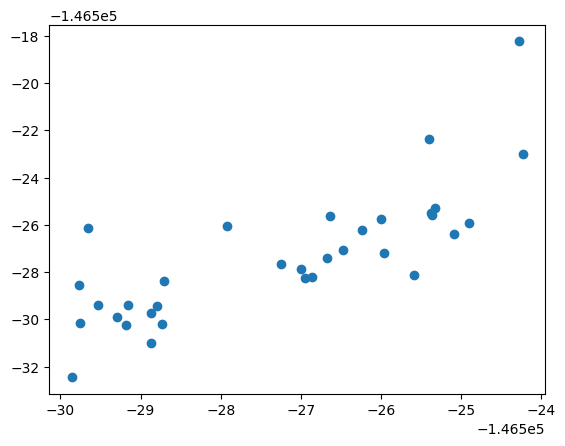

In [52]:
plt.scatter(out.detach().cpu().numpy(),batch.energy.detach().cpu().numpy())
#plt.plot([1,1,2])

In [15]:
with torch.no_grad():
    out=model.inner(batch)


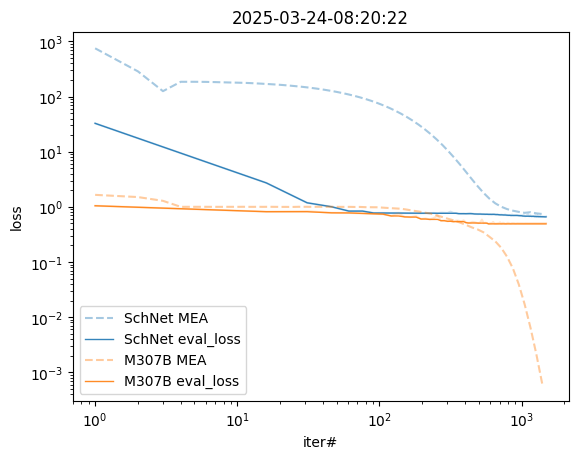

In [14]:
import datetime
ts=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
tsfs=datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
for model,c in zip(models,['tab:'+cn for cn in ('blue','orange','green','red','purple','brown','pink','gray','olive','cyan')]):
    plt.plot(pd.Series(model.train_loss_record),label=model.name+' MEA',linestyle='--',alpha=0.4,c=c)
    plt.plot(pd.Series(model.test_loss_record),alpha=0.2,c=c)
    plt.plot(pd.Series(model.test_loss_record).cummin(),label=model.name+' eval_loss',alpha=0.9,c=c,lw=1)
    
#plt.xticks(1.1**np.arange(len(record_loss_rgcn)))
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.title(ts)
plt.ylabel("loss")
plt.xlabel("iter#")
plt.gcf().savefig(f"loss_record-md17-energy-{tsfs}.svg")

DataBatch(pos=[768, 3], z=[768], energy=[64], force=[768, 3], batch=[768], ptr=[65], atom_type=[768])